#### Часть 1. Генерация стилей

In [9]:
import os
import numpy as np
from PIL import Image

from styles import styles, styles_count

Так как среди причесок есть те, которые не встретились в выборке, воспользуемся аддитивным сглаживаем, чтобы при генерации была возможность получить каждый вариант прически.

In [2]:
styles_count['прическа'] = list(map(lambda x : x + 1, styles_count['прическа']))

Посчитаем вероятности получения каждого из значений признаков.

In [3]:
styles_probs = {}

for feature, features_cnt in styles_count.items():
    features_total = sum(features_cnt)
    styles_probs[feature] = list(map(lambda x : x / features_total, features_cnt))

Делая предположение о независимости признаков, воспользуемся наивной байесовской моделью для получения вероятностей комбинаций признаков.

In [4]:
from itertools import product
from functools import reduce

multiply_elements = lambda x, y: x * y

# все возможные комбинации стилей
combs_features = product(*styles.values())

# все возможные комбинации вероятностей
multiply_elements = lambda x, y: x * y

combs_probs = map(lambda x : reduce(multiply_elements, x), product(*styles_probs.values()))

combinations = dict(zip(combs_features, combs_probs))

Посмотрим, что получилось.

In [5]:
from pprint import pprint 
pprint(combinations)

{('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'белый'): 4.001684210526315e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'зеленый'): 5.335578947368421e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'красный'): 4.6686315789473686e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'оранжевый'): 4.001684210526315e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'розовый'): 5.335578947368421e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'серый'): 4.001684210526315e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'синий'): 3.334736842105263e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'комбинезон', 'черный'): 2.6677894736842104e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'футболка с V-вырезом', 'белый'): 1.333894736842105e-05,
 ('длинные в пучок', 'блонд', 'круглые очки', 'футболка с V-вырезом', 'зеленый'): 1.7785263157894733e-05,
 ('длинные в пучок', 'блонд', 'кру

In [6]:
EPS = 1e-6

(1 - EPS) <= sum(combinations.values()) <= (1 + EPS)

True

Возьмем все, что у нас получилось, и обернем в генератор, который для инициализации будет принимать исходные словари и возвращать случайный стиль.

In [7]:
from collections.abc import Generator
import random

class StylesGenerator(Generator):
    def __init__(self, styles, styles_count):

        # аддитивное сглаживание для признаков, где есть ни разу не встретившиеся значения
        for style, counts in styles_count.items():
            if 0 in counts:
                styles_count[style] = list(map(lambda x : x + 1, counts))

        # вероятности получения каждого из значений признаков
        styles_probs = {}
        for feature, features_cnt in styles_count.items():
            features_total = sum(features_cnt)
            styles_probs[feature] = list(map(lambda x : x / features_total, features_cnt))

        multiply_elements = lambda x, y: x * y
        # все возможные комбинации стилей
        combs_features = product(*styles.values())

        # все возможные комбинации вероятностей
        multiply_elements = lambda x, y: x * y  
        combs_probs = map(lambda x : reduce(multiply_elements, x), product(*styles_probs.values()))

        self.combinations = dict(zip(combs_features, combs_probs))
        
    def send(self, ignored_arg):
        chosen_style, = random.choices(list(self.combinations.keys()), weights=list(self.combinations.values()), k=1)
        chosen_prob = self.combinations[chosen_style]
        return chosen_style, chosen_prob
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration

Сгенерируем 5 стилей.

In [8]:
sg = StylesGenerator(styles, styles_count)

for i in range(5):
    print(next(sg))

(('длинные прямые', 'серебристо серый', 'круглые очки', 'футболка с V-вырезом', 'синий'), 0.0010671157894736841)
(('нет волос', 'черный', 'нет очков', 'футболка с круглым вырезом', 'белый'), 0.00019712)
(('длинные прямые', 'серебристо серый', 'круглые очки', 'комбинезон', 'зеленый'), 0.005122155789473683)
(('длинные прямые', 'серебристо серый', 'круглые очки', 'футболка с круглым вырезом', 'красный'), 0.00473088)
(('нет волос', 'пастельный розовый', 'круглые очки', 'футболка с V-вырезом', 'красный'), 6.224842105263158e-05)


#### Часть 2. Генерация аватаров.

Создадим массив, где будем собирать статистику по пикселям в изображениях следующего размера: размер исходного изображения + каждому пикселю будет соответствовать массив А размера 256 (количество доступных цветов).

Впоследствии, при проходе по всем изображениям для каждого пикселя каждого изображения будет выполнено следующее: A[значение пикселя] += 1, после чего получим вероятностное распределение для каждого пикселя.

Посчитаем статистику. Так как весьма затратно по памяти рассматривать вероятностное пространство с мощностью, равной размеру изображения * количество каналов * количество доступных интенсивностей, было разрешено рассматривать допущение, что каждый пиксель в каждом канале имеет свое вероятностное распределение. Изначально попробуем осуществить генерацию без аддитивного сглаживания.

In [10]:
avatars_paths = os.listdir('./avatars/')
img_shape = np.asarray(Image.open(os.path.join('./avatars/', avatars_paths[0])).convert("RGB")).shape

imgs_stat = np.zeros((*img_shape, 256))
x, y, channel = np.indices(img_shape)

for avatar_path in avatars_paths:
    img = Image.open(os.path.join('./avatars/', avatar_path))
    np_img = np.asarray(img.convert("RGB"))
    imgs_stat[x, y, channel, np_img] += 1

imgs_stat /= len(avatars_paths)

Попробуем сгенерировать аватар.

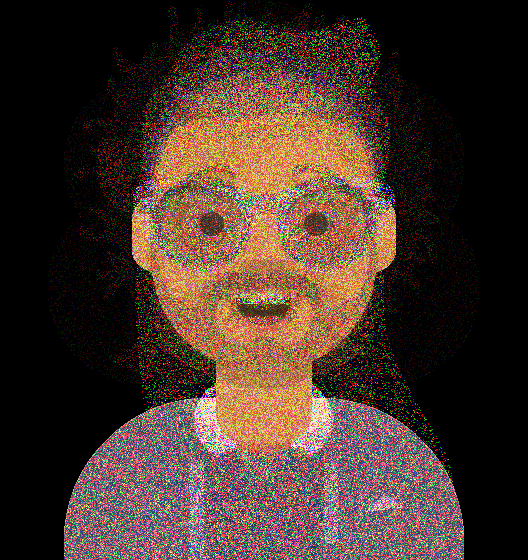

In [11]:
generated_img = np.apply_along_axis(lambda px_probs : np.random.choice(256, p=px_probs), axis=-1, arr=imgs_stat)

Image.fromarray(generated_img.astype("uint8"))

Напишем генератор, который будет инициализироваться путем до папки с аватарами и генерировать изображения на их основе.

In [12]:
class AvatarsGenerator(Generator):
    def __init__(self, avatars_path, mle=False):

        avatars_paths = os.listdir(avatars_path)
        img_shape = np.asarray(Image.open(os.path.join(avatars_path, avatars_paths[0])).convert("RGB")).shape

        if mle:
            imgs_stat = np.ones((*img_shape, 256))
            norm = 256 + len(avatars_paths)
        else:
            imgs_stat = np.zeros((*img_shape, 256))
            norm = len(avatars_paths)

        x, y, channel = np.indices(img_shape)

        for avatar_path in avatars_paths:
            img = Image.open(os.path.join(avatars_path, avatar_path))
            np_img = np.asarray(img.convert("RGB"))
            imgs_stat[x, y, channel, np_img] += 1

        self.imgs_stat = imgs_stat / norm
        
    def send(self, ignored_arg):
        generated_array = np.apply_along_axis(lambda px_probs : np.random.choice(256, p=px_probs), axis=-1, arr=self.imgs_stat)
        return Image.fromarray(generated_array.astype("uint8"))
        
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration

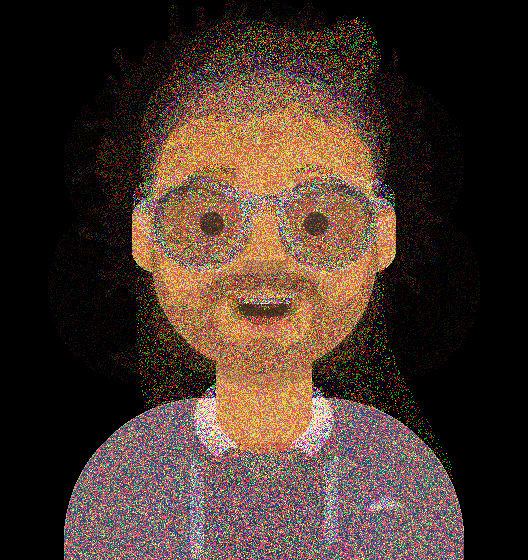

In [13]:
ag = AvatarsGenerator('./avatars/')

next(ag)

Попробуем сгенерировать изображение с аддитивным сглаживанием.

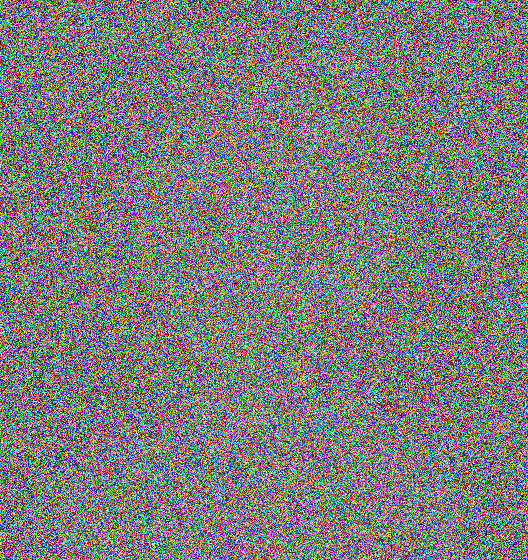

In [14]:
ag_mle = AvatarsGenerator('./avatars/', mle=True)

next(ag_mle)

Получаем шумовое изображение. Связано это с тем, что при аддитивном сглаживании мы даем шанс реализоваться каждой интенсивности от 0 до 255 с маленькой, но не нулевой вероятностью, а так как у нас всего 11 аватаров, для значительной части пикселей определенная интенсивность в определенном канале в датасета встречается один раз, поэтому для таких пикселей вероятность получить наблюдаемую интенсивность равна вероятности получить какую-то из 2 случайных ненаблюдаемых в датасете интенсивностей.

Сохраним в папку `self_made_avatars` 5 сгенерированных аватаров без применения аддитивного сглаживания.

In [18]:
ag = AvatarsGenerator('./avatars/')

for i in range(5):
    generated_avatar = next(ag)
    generated_avatar.save(os.path.join('./self_made_avatars/', f"{i}.png"))